In calculation, the atomic unit is applied.

$800 nm -> \omega_0 = 0.057 a.u.$, $400 nm -> \omega_1 = 0.114 a.u.$

Conversion relationship between wavelength and frequency, $f = C/\omega$, $C = 137 \ in\  a.u.$

The fundamental frequency is $800 nm$.

In [1]:
%load_ext Cython

In [2]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [3]:
omega_0 = 0.057

Define the pulse duration of laser in atomic unit, here $~ 15 fs$. $1fs = 41 a.u.$

In [4]:
width = 5.0 * 41.0

Define the electronic field amplitude of laser, $ I \ in \ Wcm^{-2} = 3.51 \times 10^{16} \times (E^2 \ in \ a.u.) $

In [5]:
E = 0.08

Define the sampling in time domain, $0.05 \ fs$ is feasible for $400 \ nm$, corresponding to $~ 2 \ a.u.$.

In [6]:
dt = 0.1
t_n = arange (-10, 10, dt)

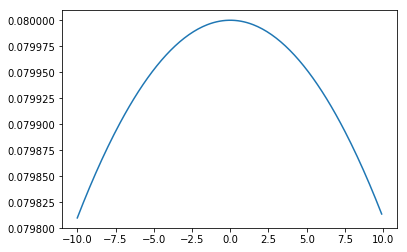

In [7]:
%matplotlib inline
env_0 = E * exp (- t_n ** 2 / width ** 2)
plot(t_n, env_0)

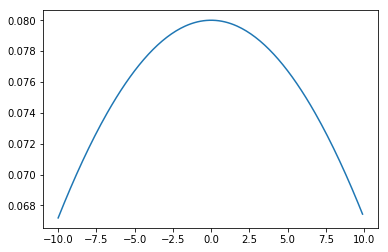

In [8]:
E_0 = env_0 * cos(omega_0 * t_n)
plot(t_n, E_0)

$A(t)=-\int{E(t)dt}$

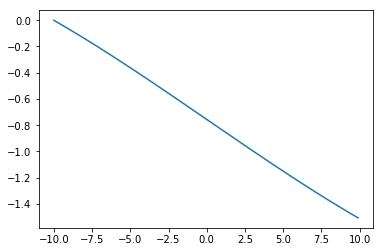

In [9]:
A = zeros(E_0.size, float)
for i in xrange(E_0.size - 1):
    A[i + 1] = A[i] + E_0[i] * dt
A_0 = - A
plot (t_n, A_0)

Define the dipole function, $D(p)=-i2^{7/2}p/[\pi(p^2+1)^3]$

In [11]:
%%cython
#%%file HHG_Cal.pyx

import cython
import numpy as np
cimport numpy as np
from libcpp.vector cimport vector
#from libc.math cimport exp


@cython.boundscheck(False)
@cython.wraparound(False)

cdef inline double complex Dipole(double p):
    return - 1j * 11.3137 * p / (3.1415926 * (p * p + 1) * (p * p + 1) * (p * p + 1))

def HHG_Cal(np.ndarray[dtype = np.double_t, ndim = 1] A, np.ndarray[dtype = np.double_t, ndim =1] E, double dt):

    cdef np.ndarray[dtype = np.double_t, ndim = 1] hhg_temp = np.zeros (A.size)
    cdef int i, j, n
    cdef double A_int, S_int, p_pm
    cdef double complex hhg_int, D_co, D
    n = A.size

    for i in range(n):
    
        A_int = 0.0
        hhg_int = 0.0
        S_int = 0.0
        D_co = 0.0
        D = 0.0
    
        for j in range(1, i):
            A_int = A_int + A[i - j] * dt
            p_pm = - A_int / (j * dt)
            D_co = np.conj (Dipole (p_pm + A[i]))
            D = Dipole (p_pm + A[i - j])
            S_int = S_int + (0.5 * (p_pm + A[i - j]) * (p_pm + A[i - j]) + 0.5) * dt
            hhg_int = hhg_int + (2 * 3.1415926 /(1j * j * dt)) ** 1.5 * D_co * D * E[i - j] * np.exp(-1j * S_int) * dt
        
        hhg_temp[i] = np.real(hhg_int)
        
    return hhg_temp


CompileError: command 'gcc' failed with exit status 1

In [11]:
#import HHG_Cal
#import numpy as np
#hg = np.zeros (A_0.size, dtype = complex128)
HHG_Cal(A_0, E_0, dt)
#hhg_temp = -1j * hhg
#plot(t_n, imag(hhg_temp))
#plot(t_n, abs(hhg_temp))

array([ 0.        ,  0.        ,  0.        ,  0.00040755,  0.00102902,
        0.00182079,  0.00276527,  0.00385291,  0.00507726,  0.00643315,
        0.00791589,  0.00952087,  0.0112433 ,  0.01307812,  0.01501989,
        0.01706278,  0.01920053,  0.02142647,  0.02373348,  0.02611403,
        0.02856019,  0.03106367,  0.03361582,  0.03620766,  0.03882993,
        0.04147313,  0.04412753,  0.04678321,  0.04943015,  0.05205819,
        0.05465716,  0.05721686,  0.0597271 ,  0.06217782,  0.06455905,
        0.06686098,  0.06907404,  0.07118888,  0.07319647,  0.07508811,
        0.07685547,  0.07849064,  0.07998617,  0.08133508,  0.08253092,
        0.08356778,  0.08444035,  0.08514391,  0.08567436,  0.08602826,
        0.08620283,  0.08619599,  0.08600631,  0.08563311,  0.08507638,
        0.08433684,  0.08341591,  0.0823157 ,  0.08103904,  0.07958943,
        0.07797106,  0.07618874,  0.07424796,  0.0721548 ,  0.06991592,
        0.06753856,  0.06503048,  0.06239993,  0.05965564,  0.05

In [ ]:
plot(t_n, real(hhg_temp))
#xlim(-50, 0)

In [ ]:
fre = fft.fft(2 * real(hhg_temp))
plot(log10(abs(fre)))
xlim([0, 500])

In [ ]:
Up = 0.5 + 3.17 * 0.08 **2 /(4 * omega_0**2)

In [ ]:
w = 2* pi* fft.fftfreq(len(t_n), dt)

In [ ]:
plot(w, log10(abs(fre)))
axvline(Up)
xlim(0,3)